<a href="https://colab.research.google.com/github/rakakOB/IMS/blob/main/C_3308_Detectron2_Instance_3D_EM_Platelet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Detectron2**

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15868, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 15868 (delta 44), reused 14 (delta 14), pack-reused 15782 (from 3)
Receiving objects: 100% (15868/15868), 6.42 MiB | 16.47 MiB/s, done.
Resolving deltas: 100% (11547/11547), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your en

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

def print_directory_contents(path):
    """Prints all files and directories in the given path."""
    try:
        items = os.listdir(path)
        for item in items:
            print(item)
    except FileNotFoundError:
        print(f"Error: Directory '{path}' not found.")
    except PermissionError:
      print(f"Error: Permission denied to access '{path}'.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Get the current working directory
current_directory = os.getcwd()
print("Current directory:")
print_directory_contents("/content/drive/MyDrive")

Current directory:
XYZ15139712371.pdf
R4.pdf
Colab Notebooks
Image_detection.v2-2025-05-09-4-28pm.yolov11.zip
models
Image_detection.v3i.yolov11.zip


In [6]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("/content/drive/MyDrive/Image_detection.v3i.yolov11.zip", 'r') as zObject:

	# Extracting all the members of the zip
	# into a specific location.
	zObject.extractall(
		path="/content/train16")

# Train on a custom dataset

In [8]:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "/content/runs/pose/train16/train/labels", "/content/runs/pose/train16/train/images")
# register_coco_instances("my_dataset_val", {}, "/content/runs/pose/train16/valid/labels", "/content/runs/pose/train16/valid/images")



Let us extract the metadata and dataset dictionaries for both training and validation datasets. These can be used later for other purposes, like visualization, model training, evaluation, etc. We will see a visualization example right away.

In [9]:
import os
import cv2
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

def load_yolo_dataset(dataset_dir, annotations_dir, class_names):
    dataset_dicts = []
    for idx, image_file in enumerate(os.listdir(dataset_dir)):
        if not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        record = {}
        image_path = os.path.join(dataset_dir, image_file)
        label_path = os.path.join(annotations_dir, os.path.splitext(image_file)[0] + '.txt')

        # Read image dimensions
        image = cv2.imread(image_path)
        height, width = image.shape[:2]

        record["file_name"] = image_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        # Parse YOLO annotations
        objs = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    w = float(parts[3])
                    h = float(parts[4])

                    # Convert normalized YOLO to absolute coordinates
                    x = (x_center - w/2) * width
                    y = (y_center - h/2) * height
                    w = w * width
                    h = h * height

                    obj = {
                        "bbox": [x, y, w, h],
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "category_id": class_id,
                    }
                    objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

In [10]:
# Define paths
train_dir = "/content/train16/train/images"
train_annotations_dir = "/content/train16/train/labels"
val_dir = "/content/train16/valid/images"
val_annotations_dir = "/content/train16/valid/labels"

test_dir = "/content/train16/test/images"
test_annotations_dir = "/content/train16/test/labels"


# List your class names (order must match YOLO class IDs)
CLASS_NAMES = ['model img', 'Doc img', 'internet img', 'Mind-maps', 'Sketch img', 'graph img']  # Replace with your classes

# Register datasets
DatasetCatalog.register("my_dataset_train", lambda: load_yolo_dataset(train_dir, train_annotations_dir, CLASS_NAMES))
MetadataCatalog.get("my_dataset_train").set(thing_classes=CLASS_NAMES)

DatasetCatalog.register("my_dataset_val", lambda: load_yolo_dataset(val_dir, val_annotations_dir, CLASS_NAMES))
MetadataCatalog.get("my_dataset_val").set(thing_classes=CLASS_NAMES)

DatasetCatalog.register("my_dataset_test", lambda: load_yolo_dataset(test_dir, test_annotations_dir, CLASS_NAMES))
MetadataCatalog.get("my_dataset_test").set(thing_classes=CLASS_NAMES)


namespace(name='my_dataset_test',
          thing_classes=['model img',
                         'Doc img',
                         'internet img',
                         'Mind-maps',
                         'Sketch img',
                         'graph img'])

In [11]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

In [12]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

test_metadata = MetadataCatalog.get("my_dataset_test")
test_dataset_dicts = DatasetCatalog.get("my_dataset_test")


In [13]:
from matplotlib import pyplot as plt

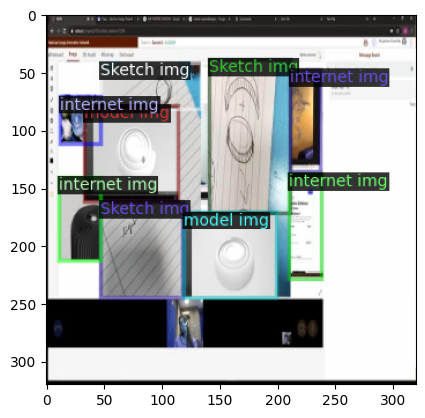

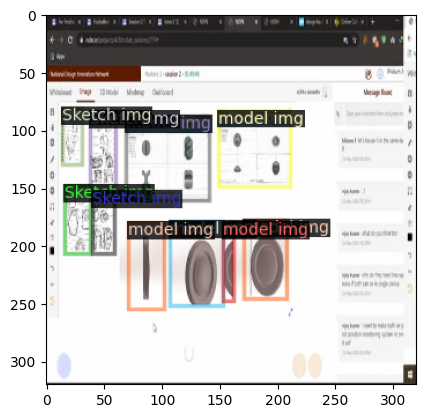

In [14]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# Train

Now we are ready to train a Mask R-CNN model using the Detectron2 library. We start by setting up a configuration file (.cfg) for the model. The configuration file contains many details including the output directory path, training dataset information, pre-trained weights, base learning rate, maximum number of iterations, etc.

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/models/Detectron2_Models_IGI"

# Change this line in your config:
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.DATALOADER.NUM_WORKERS = 2

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1400    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # We have [n...] classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[05/09 11:20:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 103MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


Train

In [ ]:
trainer.train() #Start the training process

[05/09 11:20:58 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/09 11:21:07 d2.utils.events]:  eta: 0:07:03  iter: 19  total_loss: 2.819  loss_cls: 1.925  loss_box_reg: 0.637  loss_rpn_cls: 0.209  loss_rpn_loc: 0.0476    time: 0.2960  last_time: 0.3206  data_time: 0.0159  last_data_time: 0.0041   lr: 4.9953e-06  max_mem: 1742M
[05/09 11:21:18 d2.utils.events]:  eta: 0:06:38  iter: 39  total_loss: 2.709  loss_cls: 1.785  loss_box_reg: 0.5871  loss_rpn_cls: 0.2277  loss_rpn_loc: 0.03934    time: 0.2995  last_time: 0.3338  data_time: 0.0107  last_data_time: 0.0113   lr: 9.9902e-06  max_mem: 1742M
[05/09 11:21:24 d2.utils.events]:  eta: 0:06:32  iter: 59  total_loss: 2.412  loss_cls: 1.496  loss_box_reg: 0.7016  loss_rpn_cls: 0.1512  loss_rpn_loc: 0.0332    time: 0.2975  last_time: 0.3089  data_time: 0.0081  last_data_time: 0.0114   lr: 1.4985e-05  max_mem: 1742M
[05/09 11:21:30 d2.utils.events]:  eta: 0:06:29  iter: 79  total_loss: 2.019  loss_cls: 1.223  loss_box_reg: 0.651  loss_rpn_cls: 0.1171  loss_rpn_loc: 0.02684    time: 0.3000  last_time: 

Save the config file, for potential future use

In [ ]:
# # Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output

In [ ]:
import yaml
# Save the configuration to a config.yaml file
config_yaml_path = "/content/drive/MyDrive/models/Detectron2_Models_IGI/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

# Inference & evaluation using the trained model

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/09 11:28:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/models/Detectron2_Models_IGI/model_final.pth ...


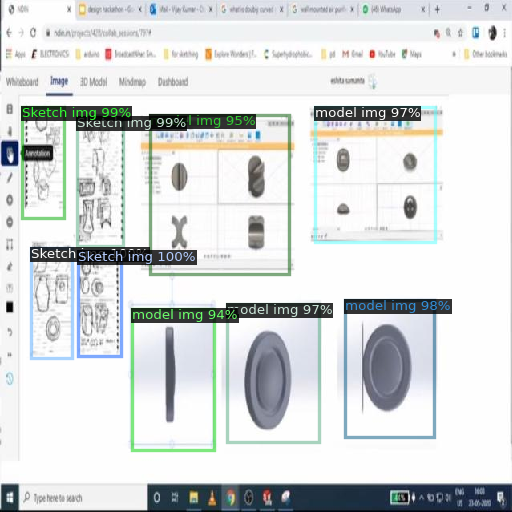

In [ ]:
# HERE.
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.8,
                  #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Check average precision and recall.

In [19]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[05/23 10:11:52 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[05/23 10:11:52 d2.evaluation.coco_evaluation]: Trying to convert 'my_dataset_val' to COCO format ...
[05/23 10:11:52 d2.data.datasets.coco]: Converting annotations of dataset 'my_dataset_val' to COCO format ...)
[05/23 10:11:52 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/23 10:11:52 d2.data.datasets.coco]: Conversion finished, #images: 9, #annotations: 50
[05/23 10:11:52 d2.data.datasets.coco]: Caching COCO format annotations at './output/my_dataset_val_coco_format.json' ...
[05/23 10:11:52 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |   category   | #instances   |
|:----------:|:-------------|:----------:|:-------------|:------------:|:-------------|
| model img  | 14           |  Doc img   | 4            | internet img | 12           |
| Mind-maps  | 0            | Sket

**Load a new image and perform inference on it.**

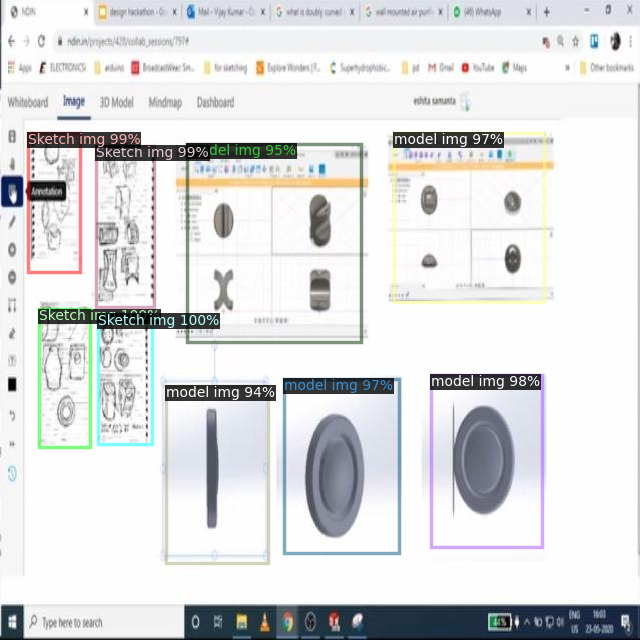

In [ ]:

# new_im = cv2.imread("/content/runs/pose/train16/test/images/rakesh2_frame_669_png.rf.2cdc96dfeb6bbc7752ae8362654e8b07.jpg")
# new_im = cv2.imread("/content/runs/pose/train16/test/images/rakesh_frame_455.png")
new_im = cv2.imread("/content/train16/valid/images/g-21-_png.rf.b02ecc53839b827db6c19ed51529823e.jpg")

outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])


**Process multiple images in a directory and save the results in an output directory**

In [ ]:
# Directory path to the input images folder
input_images_directory = "/content/train16/valid/images"

# Output directory where the segmented images will be saved
output_directory = "/content/detections"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")


Segmentation of all images completed.


In [ ]:
# Compress detections folder
from zipfile import ZipFile
import os

def zip_directory(folder_path, zip_path):
    with ZipFile(zip_path, 'w') as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path,
                          arcname=os.path.relpath(file_path, folder_path))

# Usage
zip_directory('/content/detections', '/content/detect_IGI.zip')

### Custom Model: call with pretrained weights and it's respective config file.


In [16]:
# custom model

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
import cv2



# ---- Load Custom Model ----
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/models/Detectron2_Models_IGI_DS2/config.yaml")  # Your custom config
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/models/Detectron2_Models_IGI_DS2/model_final.pth"  # Your trained weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Confidence threshold
# cfg.MODEL.DEVICE = "cpu"  # or "cuda"

# ---- Set Class Names ----
class_names = ['model img', 'Doc img', 'internet img', 'Mind-maps', 'Sketch img', 'graph img']  # Replace with your actual classes
MetadataCatalog.get("my_dataset_train").thing_classes = class_names
metadata = MetadataCatalog.get("my_dataset_train")

# ---- Inference ----
predictor = DefaultPredictor(cfg)


[05/23 10:10:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/models/Detectron2_Models_IGI_DS2/model_final.pth ...


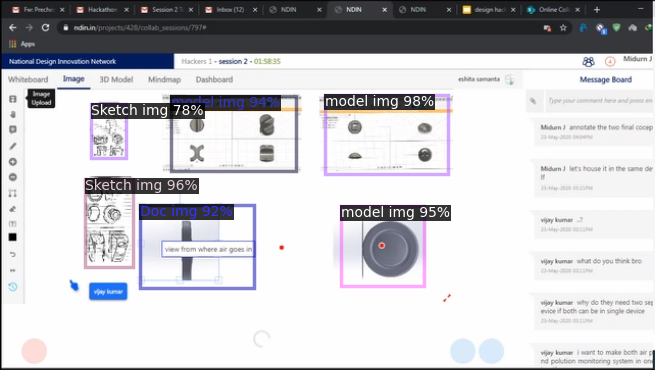

In [ ]:
# Particular
image = cv2.imread("/content/ect_images/e (65).png")

# Run prediction
outputs = predictor(image)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(image[:, :, ::-1], metadata=metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])


In [17]:

# Metadata and dataset.
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


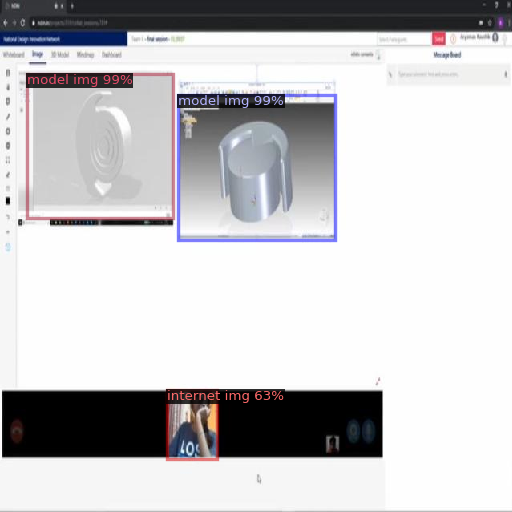

In [18]:
# Random
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.8,
                  #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])


# # Visualize some random samples
# for d in random.sample(train_dataset_dicts, 2):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
#     vis = visualizer.draw_dataset_dict(d)
#     plt.imshow(vis.get_image()[:, :, ::-1])
#     plt.show()

In [ ]:
# ALL

# Directory path to the input images folder
input_images_directory = "/content/ect_images"

# Output directory where the segmented images will be saved
output_directory = "/content/detections2"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")

# Compress detections folder
from zipfile import ZipFile
import os

def zip_directory(folder_path, zip_path):
    with ZipFile(zip_path, 'w') as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path,
                          arcname=os.path.relpath(file_path, folder_path))

# Usage
zip_directory('/content/detections2', '/content/detect_IGI2.zip')
print("Compress complete.")

Segmentation of all images completed.


# TRIALS

In [ ]:
# Test_5

from detectron2.structures import Boxes, pairwise_iou

def filter_nested_boxes(instances, ioa_threshold=0.9):
    """
    Fixed version to handle box indexing properly
    """
    if len(instances) == 0:
        return instances

    boxes = instances.pred_boxes
    scores = instances.scores
    classes = instances.pred_classes

    # Sort by descending scores and convert to list
    sorted_ids = torch.argsort(-scores).tolist()
    keep = []

    for i in sorted_ids:
        # Use [i] to maintain 2D tensor shape
        box_i = boxes[[i]]  # <-- Fix here: double bracket indexing
        is_nested = False

        for j in keep:
            box_j = boxes[[j]]  # <-- Fix here: double bracket indexing
            intersection = pairwise_iou(box_i, box_j).item()
            area_i = box_i.area().item()

            if (intersection / area_i) > ioa_threshold:
                is_nested = True
                break

        if not is_nested:
            keep.append(i)

    # Convert to tensor for proper indexing
    keep = torch.tensor(keep)
    return instances[keep]

[05/10 11:18:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/models/Detectron2_Models_IGI/model_final.pth ...


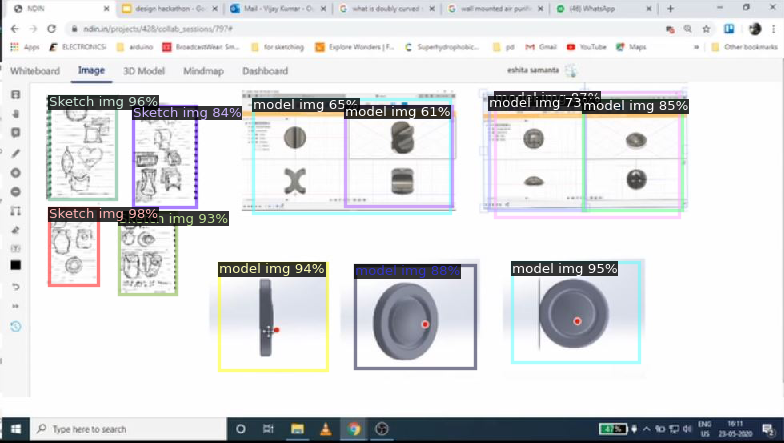

In [ ]:
# TEST_5 cont.
# ---- Load Custom Model ----
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/models/Detectron2_Models_IGI/config.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/models/Detectron2_Models_IGI/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# ---- Set Class Names ----
class_names = ['model img', 'Doc img', 'internet img', 'Sketch img', 'graph img']
MetadataCatalog.get("my_dataset_train").thing_classes = class_names  # UNCOMMENT THIS
metadata = MetadataCatalog.get("my_dataset_train")

# ---- Inference ----
predictor = DefaultPredictor(cfg)
image = cv2.imread("/content/ect_images/g (25).png")
outputs = predictor(image)

# Filter nested boxes
filtered_instances = filter_nested_boxes(outputs["instances"].to("cpu"))

class CustomVisualizer(Visualizer):
    def _draw_text(self, text, position, color="g", font_scale=None):
        if font_scale is None:
            font_scale = 0.4  # Your custom scale
        return super()._draw_text(text, position, color, font_scale)

v = CustomVisualizer(
    image[:, :, ::-1],
    metadata=metadata,
    scale=0.8
)
out = v.draw_instance_predictions(filtered_instances)
cv2_imshow(out.get_image()[:, :, ::-1])

# Trials Continued.

In [20]:
# TEST_1
# Detections in csv

import csv
import os
import cv2
from detectron2.structures import BoxMode

# Assuming you have already defined the 'predictor' object and loaded the detection model
# Make sure 'metadata' is properly defined (e.g. metadata = MetadataCatalog.get("my_dataset_train"))
metadata = MetadataCatalog.get("my_dataset_train")  # Define metadata here

input_images_directory = "/content/train16/valid/images"
output_csv_path = "/content/drive/MyDrive/models/validation_set_output_objects.csv"

with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Modified header for detection-only outputs
    csvwriter.writerow(["File Name", "Class Name", "Object Number",
                       "Area", "Centroid", "BoundingBox (XYXY)", "Confidence"])

    for image_filename in os.listdir(input_images_directory):
        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)
        outputs = predictor(new_im)

        # Get detection outputs
        instances = outputs["instances"]

        # For detection-only models, use these fields:
        boxes = instances.pred_boxes.tensor.cpu().numpy()  # Get bounding boxes in XYXY format
        scores = instances.scores.cpu().numpy()  # Confidence scores
        class_labels = instances.pred_classes.cpu().numpy()  # Class IDs

        # for obj_idx in range(len(instances)):
        #     x1, y1, x2, y2 = boxes[obj_idx]

        #     # Calculate properties from bounding box
        #     area = (x2 - x1) * (y2 - y1)
        #     centroid = ((x1 + x2) / 2, (y1 + y2) / 2)
        #     bbox = (x1, y1, x2, y2)

        #     class_id = class_labels[obj_idx]
        #     class_name = metadata.thing_classes[class_id]
        #     confidence = scores[obj_idx]

        #     csvwriter.writerow([
        #         image_filename,
        #         class_name,
        #         obj_idx + 1,  # Object number
        #         area,
        #         centroid,
        #         bbox,
        #         confidence  # Added confidence score
        #     ])

        for i, (box, score, class_id) in enumerate(zip(boxes, scores, class_labels)):
            # Calculate geometric properties from bounding box
            x0, y0, x1, y1 = box
            width = x1 - x0
            height = y1 - y0
            area = width * height
            centroid = ((x0 + x1)/2, (y0 + y1)/2)

            # Get class name from metadata
            class_name = metadata.thing_classes[class_id]

            # Write to CSV
            csvwriter.writerow([
                image_filename,
                class_name,
                i+1,  # Object number
                area,
                centroid,
                (x0, y0, x1, y1),  # XYXY format
                f"{score:.2f}"  # Confidence score
            ])

print("Detection results saved to CSV file.")

Detection results saved to CSV file.


<ipython-input-39-02687d10a119>:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)


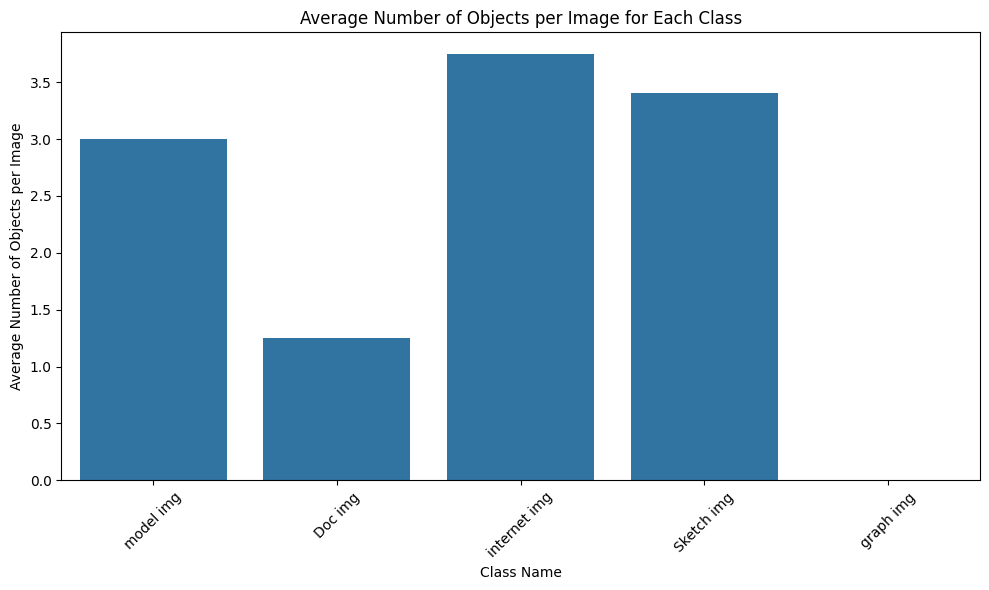

<ipython-input-39-02687d10a119>:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)


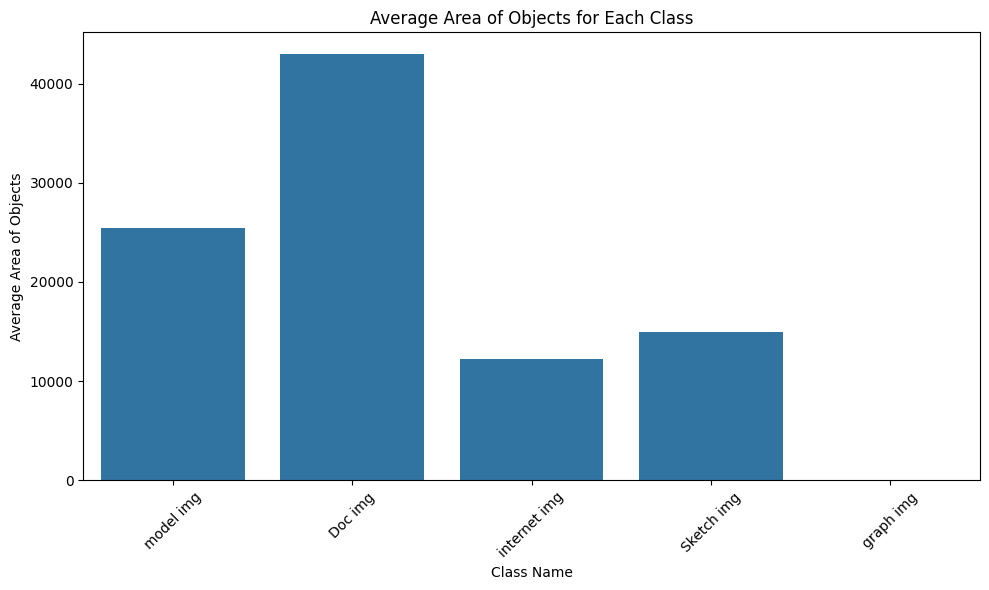

In [ ]:
# TEST_2
# Generate Plot

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the CSV file containing the object-level information
csv_file_path = "/content/drive/MyDrive/models/output_objects.csv"  # Update with your CSV file path

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Get class names from train_metadata.thing_classes
class_names = train_metadata.thing_classes

# Group the data by both "File Name" and "Class Name" and calculate the average number of objects per image for each class
# first group the data by both "File Name" and "Class Name" and count the number of objects within each group.
#Then, group the data by "Class Name" only and calculate the mean of the counts, which gives us the average number of objects per image for each class.
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()

# Plot: Average number of objects per image for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()


# Group the data by class and calculate the average area of objects for each class
avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()

# Plot: Average area of objects for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Area of Objects")
plt.title("Average Area of Objects for Each Class")
plt.tight_layout()
plt.show()


In [ ]:
# TEST_3
# Visualize

import os
import cv2
from detectron2.utils.visualizer import Visualizer

# Directory paths
input_images_directory = "/content/ect_images"
output_directory = "/content/drive/MyDrive/models/test_results_instance"

# Create output directory if needed
os.makedirs(output_directory, exist_ok=True)

for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Get predictions
    outputs = predictor(new_im)
    instances = outputs["instances"].to("cpu")

    # Visualize predictions
    v = Visualizer(new_im[:, :, ::-1],
                   metadata=train_metadata,  # Make sure this is your actual metadata object
                   scale=1.0)
    out = v.draw_instance_predictions(instances)

    # Save visualized image
    output_path = os.path.join(output_directory, f"detected_{image_filename}")
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Detection visualization completed.")

Detection visualization completed.


# END

# Dataset2

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# Dataset
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2  # Colab's CPU has 2 cores

# Model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Input (Optimized for T4 VRAM)
cfg.INPUT.MIN_SIZE_TRAIN = (600, 800)  # Randomly choose between 600-800px
cfg.INPUT.MAX_SIZE_TRAIN = 1333
cfg.INPUT.RANDOM_FLIP = "horizontal"

# Solver (Batch=2 for stability)
cfg.SOLVER.IMS_PER_BATCH = 2  # Critical for T4!
cfg.SOLVER.BASE_LR = 0.000125  # Scaled from 0.00025 for batch=2
cfg.SOLVER.MAX_ITER = 3000
cfg.SOLVER.STEPS = (2000,)
cfg.SOLVER.GAMMA = 0.1

# Additional T4 Optimizations
cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True  # Prevent gradient explosions
cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # Reduce from 512

# Mixed Precision Training (FP16)
# cfg.MODEL.DEVICE = "cuda"
# cfg.SOLVER.AMP.ENABLED = True  # Requires PyTorch 1.6+

# Output
cfg.OUTPUT_DIR = "/content/drive/MyDrive/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[05/21 16:06:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 136MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


In [ ]:
trainer.train()


In [ ]:
# # Visualize sample annotations
# dataset_dicts = get_yolo_dicts(train_img_dir, train_label_dir, class_names)
# for d in random.sample(dataset_dicts, 3):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
#     vis = visualizer.draw_dataset_dict(d)
#     cv2_imshow(vis.get_image()[:, :, ::-1])

Save config file.

In [ ]:
import yaml
# Save the configuration to a config.yaml file
config_yaml_path = "/content/drive/MyDrive/models/Detectron2_Models_IGI_DS2/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

## Inference.

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
# HERE.
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.8,
                  #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

In [ ]:

# new_im = cv2.imread("/content/runs/pose/train16/test/images/rakesh2_frame_669_png.rf.2cdc96dfeb6bbc7752ae8362654e8b07.jpg")
# new_im = cv2.imread("/content/runs/pose/train16/test/images/rakesh_frame_455.png")
new_im = cv2.imread("/content/train16/valid/images/g-21-_png.rf.b02ecc53839b827db6c19ed51529823e.jpg")

outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

Multiple Images. And zip them.

In [ ]:
# Directory path to the input images folder
input_images_directory = "/content/train16/valid/images"

# Output directory where the segmented images will be saved
output_directory = "/content/detections"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")

In [ ]:
# Compress detections folder
from zipfile import ZipFile
import os

def zip_directory(folder_path, zip_path):
    with ZipFile(zip_path, 'w') as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path,
                          arcname=os.path.relpath(file_path, folder_path))

# Usage
zip_directory('/content/detections', '/content/detect_IGI.zip')

# run detections on video.

In [7]:
!ls -lh "/content/detections"

ls: cannot access '/content/detections': No such file or directory


In [ ]:
# import cv2
# import os
# from google.colab.patches import cv2_imshow
# from detectron2.engine import DefaultPredictor
# from detectron2.utils.visualizer import Visualizer
# from detectron2.data import MetadataCatalog
# from detectron2.config import get_cfg
# from google.colab import drive

# # # Mount Google Drive
# # drive.mount('/content/drive')

# def process_video():
#     print('Starting video processing...')

#     # Configuration setup
#     cfg = get_cfg()
#     cfg.merge_from_file('/content/drive/MyDrive/models/Detectron2_Models_IGI_DS2/config.yaml')
#     cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/models/Detectron2_Models_IGI_DS2/model_final.pth'
#     cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
#     cfg.MODEL.DEVICE = "cuda"  # Use GPU in Colab

#     # Class setup
#     class_names = ['model img', 'Doc img', 'internet img', 'Mind-maps', 'Sketch img', 'graph img']
#     MetadataCatalog.get("my_dataset_train").thing_classes = class_names
#     metadata = MetadataCatalog.get("my_dataset_train")

#     # Initialize predictor
#     predictor = DefaultPredictor(cfg)

#     # Video paths
#     input_video = '/content/drive/MyDrive/models/ds2_videos/t20s3.mp4'
#     output_video = '/content/detections6f/ov3.mp4'
#     ddf = '/content/detections_ds5/THIS_FOLDER_WONT_GET_CREATED_DONT_WORRY'

#     # Create detection directories
#     video_name = os.path.splitext(os.path.basename(input_video))[0]
#     detections_dir = os.path.join(os.path.dirname(output_video), f"{video_name}_detections")
#     os.makedirs(detections_dir, exist_ok=True)

#     # Open video file
#     cap = cv2.VideoCapture(input_video)
#     if not cap.isOpened():
#         print(f"Error opening video file: {input_video}")
#         return

#     # Get video properties
#     frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#     frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#     fps = cap.get(cv2.CAP_PROP_FPS)

#     # # Initialize video writer
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     out = cv2.VideoWriter(output_video, fourcc, fps, (frame_width, frame_height))

#     print("Processing video...")

#     try:
#         frame_count = 0
#         while cap.isOpened():
#             ret, frame = cap.read()
#             if not ret:
#                 break

#             # Perform detection
#             outputs = predictor(frame)
#             instances = outputs["instances"]

#             # Visualize results
#             v = Visualizer(frame[:, :, ::-1], metadata=metadata)
#             visualized_frame = v.draw_instance_predictions(instances.to("cpu")).get_image()

#             # 2. Convert to BGR and verify frame format
#             vis_frame_bgr = cv2.cvtColor(visualized_frame, cv2.COLOR_RGB2BGR)

#             # Write to output
#             out.write(vis_frame_bgr)
#             # cv2.imwrite(os.path.join(detections_dir, f"frame_{frame_count}.jpg"), visualized_frame)

#             frame_count += 1
#             if frame_count % 50 == 0:
#                 print(f"Processed {frame_count} frames")
#     finally:
#         # Cleanup
#         cap.release()
#         out.release()
#         print(f"\nFinished processing! Total frames: {frame_count}")
#         print(f"Output saved to: {output_video}")

#     # # Convert for better compatibility
#     # print("\nConverting video for download...")
#     # final_output = output_video.replace('.mp4', '_final.mp4')
#     # !ffmpeg -y -i "{output_video}" -c:v libx264 "{final_output}"

#     # # Download result
#     # from google.colab import files
#     # files.download(final_output)

# # Run the processing
# process_video()

Starting video processing...
[05/23 06:27:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/models/Detectron2_Models_IGI_DS2/model_final.pth ...
Processing video...
Processed 50 frames

Finished processing! Total frames: 96
Output saved to: /content/detections6f/ov3.mp4


In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.config import get_cfg
from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

def process_video():
    print('Starting video processing...')

    # Configuration setup
    cfg = get_cfg()
    cfg.merge_from_file('/content/drive/MyDrive/models/Detectron2_Models_IGI_DS2/config.yaml')
    cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/models/Detectron2_Models_IGI_DS2/model_final.pth'
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.DEVICE = "cuda"  # Use GPU in Colab

    # Class setup
    class_names = ['model img', 'Doc img', 'internet img', 'Mind-maps', 'Sketch img', 'graph img']
    MetadataCatalog.get("my_dataset_train").thing_classes = class_names
    metadata = MetadataCatalog.get("my_dataset_train")

    # Initialize predictor
    predictor = DefaultPredictor(cfg)

    # Video paths
    # Create temporary output path in Colab's writable space
    # ddf = '/content/detections5/THIS_FOLDER_WONT_GET_CREATED_DONT_WORRY'
    input_video = '/content/drive/MyDrive/models/ds2_videos/t20s3.mp4'
    temp_output = "/content/detections5f/tov3.mp4"
    final_output = "/content/drive/MyDrive/models/ds2_videos/output_final.mp4"

    # Create detection directories
    video_name = os.path.splitext(os.path.basename(input_video))[0]
    detections_dir = os.path.join(os.path.dirname(temp_output), f"{video_name}_detections")
    os.makedirs(detections_dir, exist_ok=True)

    # Open video file
    cap = cv2.VideoCapture(input_video)
    if not cap.isOpened():
        print(f"Error opening video file: {input_video}")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # 1. Verify VideoWriter initialization
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(temp_output, fourcc, fps, (frame_width, frame_height))

    if not out.isOpened():
        raise IOError("Could not initialize VideoWriter! Check codec/frame size.")

    try:
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Get detection visualization
            outputs = predictor(frame)
            instances = outputs["instances"]
            v = Visualizer(frame[:, :, ::-1], metadata=metadata)
            vis_frame = v.draw_instance_predictions(instances.to("cpu")).get_image()

            # 2. Convert to BGR and verify frame format
            vis_frame_bgr = cv2.cvtColor(vis_frame, cv2.COLOR_RGB2BGR)
            # 0A. Save images in a folder.
            cv2.imwrite(os.path.join(detections_dir, f"frame_{frame_count}.jpg"), vis_frame_bgr)

            # 3. Write frame with verification
            out.write(vis_frame_bgr)
            frame_count += 1

            if frame_count % 50 == 0:
                print(f"✅ Written {frame_count} frames | Frame shape: {vis_frame_bgr.shape}")

    finally:
        # 4. Force release resources
        out.release()
        cap.release()
        print(f"🔒 Released resources | Final frame count: {frame_count}")

    # 5. Verify temporary file
    if not os.path.exists(temp_output):
        raise FileNotFoundError("Temporary output file not created!")

    temp_size = os.path.getsize(temp_output)
    print(f"📁 Temporary file size: {temp_size/1024:.2f} KB")

    # # 6. Convert with FFmpeg (essential for Colab)
    # print("🔧 Converting with FFmpeg...")
    # !ffmpeg -y -i "{temp_output}" -c:v libx264 -pix_fmt yuv420p "{final_output}"

    # # 7. Verify final output
    # if os.path.exists(final_output):
    #     final_size = os.path.getsize(final_output)
    #     print(f"🎉 Success! Final file size: {final_size/1024/1024:.2f} MB")
    #     files.download(final_output)
    # else:
    #     print("❌ Conversion failed")
    #     !ffmpeg -i "{temp_output}"  # Show error diagnostics


# Run the processing
process_video()

Starting video processing...
[05/23 06:38:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/models/Detectron2_Models_IGI_DS2/model_final.pth ...
✅ Written 50 frames | Frame shape: (736, 1376, 3)
🔒 Released resources | Final frame count: 96
📁 Temporary file size: 1327.32 KB


### With Time-Stamps.

In [23]:
import cv2
import os
from google.colab.patches import cv2_imshow
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.config import get_cfg
from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

def process_video():
    print('Starting video processing...')

    # Configuration setup
    cfg = get_cfg()
    cfg.merge_from_file('/content/drive/MyDrive/models/Detectron2_Models_IGI_DS2/config.yaml')
    cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/models/Detectron2_Models_IGI_DS2/model_final.pth'
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.DEVICE = "cuda"  # Use GPU in Colab

    # Class setup
    class_names = ['model img', 'Doc img', 'internet img', 'Mind-maps', 'Sketch img', 'graph img']
    MetadataCatalog.get("my_dataset_train").thing_classes = class_names
    metadata = MetadataCatalog.get("my_dataset_train")

    # Initialize predictor
    predictor = DefaultPredictor(cfg)

    # Video paths
    # Create temporary output path in Colab's writable space
    # ddf = '/content/detections5/THIS_FOLDER_WONT_GET_CREATED_DONT_WORRY'
    input_video = '/content/drive/MyDrive/models/ds2_videos/T20-S3.mp4'
    temp_output = "/content/detections5f/tov3.mp4"
    final_output = "/content/drive/MyDrive/models/ds2_videos/output_final.mp4"

    # Create detection directories
    video_name = os.path.splitext(os.path.basename(input_video))[0]
    detections_dir = os.path.join(os.path.dirname(temp_output), f"{video_name}_detections")
    os.makedirs(detections_dir, exist_ok=True)

    # Create log file path
    log_file_path = os.path.join(detections_dir, "detection_log.txt")

    # Write header if file is new
    if not os.path.exists(log_file_path):
        with open(log_file_path, "w") as f:
            f.write("Frame\tTimestamp\t" + "\t".join(class_names) + "\n")

    # Open video file
    cap = cv2.VideoCapture(input_video)
    if not cap.isOpened():
        print(f"Error opening video file: {input_video}")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # 1. Verify VideoWriter initialization
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(temp_output, fourcc, fps, (frame_width, frame_height))

    if not out.isOpened():
        raise IOError("Could not initialize VideoWriter! Check codec/frame size.")

    try:
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Get detection visualization
            outputs = predictor(frame)
            instances = outputs["instances"]

            ####################################################################

            # Calculate timestamp
            timestamp = frame_count / fps  # Seconds
            hours = int(timestamp // 3600)
            minutes = int((timestamp % 3600) // 60)
            seconds = timestamp % 60
            timestamp_str = f"{hours:02d}:{minutes:02d}:{seconds:06.3f}"

            # Count detections per class
            class_counts = {cls: 0 for cls in class_names}
            if instances.has("pred_classes"):
                pred_classes = instances.pred_classes.cpu().tolist()
                for class_id in pred_classes:
                    class_name = class_names[class_id]
                    class_counts[class_name] += 1

            ####################################################################

            v = Visualizer(frame[:, :, ::-1], metadata=metadata)
            vis_frame = v.draw_instance_predictions(instances.to("cpu")).get_image()

            # 2. Convert to BGR and verify frame format
            vis_frame_bgr = cv2.cvtColor(vis_frame, cv2.COLOR_RGB2BGR)
            # 0A. Save images in a folder.
            cv2.imwrite(os.path.join(detections_dir, f"frame_{frame_count}.jpg"), vis_frame_bgr)

            # 3. Write frame with verification
            out.write(vis_frame_bgr)
            frame_count += 1

            # 0B. Time-stamps are once in every 10 frames.
            if frame_count % 10 == 0:
              count_string = "\t".join([str(class_counts[cls]) for cls in class_names])
              log_string = (f"Frame: {frame_count}\t"
                              f"Timestamp: {timestamp_str}\t"
                              f"Counts: {count_string}")

              # Print to console
              print(log_string)

              # Write to log file
              with open(log_file_path, "a") as f:
                  f.write(f"{frame_count}\t{timestamp_str}\t{count_string}\n")

            # 50. Frame call.
            if frame_count % 50 == 0:
                print(f"✅ Written {frame_count} frames | Frame shape: {vis_frame_bgr.shape}")


    finally:
        # 4. Force release resources
        out.release()
        cap.release()
        print(f"🔒 Released resources | Final frame count: {frame_count}")
        print(f"Detection log saved to: {log_file_path}")

    # 5. Verify temporary file
    if not os.path.exists(temp_output):
        raise FileNotFoundError("Temporary output file not created!")

    temp_size = os.path.getsize(temp_output)
    print(f"📁 Temporary file size: {temp_size/1024:.2f} KB")

    # # 6. Convert with FFmpeg (essential for Colab)
    # print("🔧 Converting with FFmpeg...")
    # !ffmpeg -y -i "{temp_output}" -c:v libx264 -pix_fmt yuv420p "{final_output}"

    # # 7. Verify final output
    # if os.path.exists(final_output):
    #     final_size = os.path.getsize(final_output)
    #     print(f"🎉 Success! Final file size: {final_size/1024/1024:.2f} MB")
    #     files.download(final_output)
    # else:
    #     print("❌ Conversion failed")
    #     !ffmpeg -i "{temp_output}"  # Show error diagnostics


# Run the processing
process_video()

Starting video processing...
[05/23 10:37:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/models/Detectron2_Models_IGI_DS2/model_final.pth ...
Frame: 10	Timestamp: 00:00:00.301	Counts: 0	0	0	0	1	0
Frame: 20	Timestamp: 00:00:00.635	Counts: 0	0	0	0	1	0
Frame: 30	Timestamp: 00:00:00.969	Counts: 0	0	0	0	1	0
Frame: 40	Timestamp: 00:00:01.304	Counts: 0	0	0	0	1	0
Frame: 50	Timestamp: 00:00:01.638	Counts: 0	0	0	0	1	0
✅ Written 50 frames | Frame shape: (736, 1376, 3)
Frame: 60	Timestamp: 00:00:01.972	Counts: 0	0	0	0	1	0
Frame: 70	Timestamp: 00:00:02.307	Counts: 0	0	0	0	1	0
Frame: 80	Timestamp: 00:00:02.641	Counts: 0	0	0	0	1	0
Frame: 90	Timestamp: 00:00:02.975	Counts: 0	0	0	0	1	0
Frame: 100	Timestamp: 00:00:03.310	Counts: 0	0	0	0	1	0
✅ Written 100 frames | Frame shape: (736, 1376, 3)
Frame: 110	Timestamp: 00:00:03.644	Counts: 0	0	0	0	1	0
Frame: 120	Timestamp: 00:00:03.978	Counts: 0	0	0	0	1	0
Frame: 130	Timestamp: 00:00:04.312	Counts: 0	0	0	0	1	

# END2.

# Dataset 3

final if not Original.